In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers
from tensorflow import keras

In [5]:
df = pd.read_csv("../dataset/preprocessed_data.csv")
df

,user_id,recipe_id,date,rating,review,name,minutes,contributor_id,submitted,tags,...,sugar,sodium,protein,saturated_fat,carbohydrates,food_types,negative,neutral,positive,compound
0,7708,60599,2005-09-02,4,very good,kfc honey bbq strips,40,166019,2005-08-24,"60-minutes-or-less, time-to-make, main-ingredi...",...,40.0,37.0,78.0,4.0,10.0,Non-veg,0.000,0.238,0.762,0.4927
1,27707,60599,2005-12-22,5,better than the real,kfc honey bbq strips,40,166019,2005-08-24,"60-minutes-or-less, time-to-make, main-ingredi...",...,40.0,37.0,78.0,4.0,10.0,Non-veg,0.000,0.508,0.492,0.4404
2,35308,60599,2006-09-26,5,absolutely awesome i was speechless when i tri...,kfc honey bbq strips,40,166019,2005-08-24,"60-minutes-or-less, time-to-make, main-ingredi...",...,40.0,37.0,78.0,4.0,10.0,Non-veg,0.000,0.883,0.117,0.6590
3,19399,60599,2007-03-09,5,these taste absolutely wonderful my son in law...,kfc honey bbq strips,40,166019,2005-08-24,"60-minutes-or-less, time-to-make, main-ingredi...",...,40.0,37.0,78.0,4.0,10.0,Non-veg,0.000,0.675,0.325,0.8908
4,43887,60599,2008-02-20,0,made my own buttermilk w vinegar and milk. use...,kfc honey bbq strips,40,166019,2005-08-24,"60-minutes-or-less, time-to-make, main-ingredi...",...,40.0,37.0,78.0,4.0,10.0,Non-veg,0.000,0.929,0.071,0.4588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942363,10188,22092,2007-04-26,0,i am not going to rate this because i did have...,garlic clove chicken,65,49304,2003-02-21,"weeknight, time-to-make, course, main-ingredie...",...,1.0,7.0,53.0,29.0,2.0,Non-veg,0.071,0.929,0.000,-0.5075
942364,51769,161871,2009-09-29,5,these were so delicious my husband and i truly...,stacey e s yummy veggie burgers,21,742029,2009-08-24,"30-minutes-or-less, time-to-make, course, main...",...,11.0,24.0,10.0,0.0,8.0,Healthy,0.000,0.752,0.248,0.9609
942365,15786,33054,2008-06-23,5,wow sometimes i do not take the time to rate r...,pot roast with port stove top,115,108291,2003-12-05,"weeknight, time-to-make, course, preparation, ...",...,22.0,20.0,93.0,112.0,4.0,Veg,0.063,0.749,0.188,0.9520
942366,5051,33054,2009-01-11,4,very good i used regular port as well. the gra...,pot roast with port stove top,115,108291,2003-12-05,"weeknight, time-to-make, course, preparation, ...",...,22.0,20.0,93.0,112.0,4.0,Veg,0.000,0.584,0.416,0.8856


In [7]:
df = df.sample(frac=1, random_state=42)

user_ids = df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
recipe_ids = df["recipe_id"].unique().tolist()
recipe2recipe_encoded = {x: i for i, x in enumerate(recipe_ids)}
recipe_encoded2recipe = {i: x for i, x in enumerate(recipe_ids)}
df["user"] = df["user_id"].map(user2user_encoded)
df["recipe"] = df["recipe_id"].map(recipe2recipe_encoded)

num_users = len(user2user_encoded)
num_recipes = len(recipe_encoded2recipe)
df["rating"] = df["rating"].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Recipes: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_recipes, min_rating, max_rating
    )
)

Number of users: 192751, Number of Recipes: 194084, Min rating: 0.0, Max rating: 5.0


In [8]:
x = df[["user", "recipe"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"] / 5
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [10]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Metal device set to: Apple M1 Pro
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

EMBEDDING_SIZE = 32


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_recipes, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_recipes = num_recipes
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-1),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.recipe_embedding = layers.Embedding(
            num_recipes,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-1),
        )
        self.recipe_bias = layers.Embedding(num_recipes, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        recipe_vector = self.recipe_embedding(inputs[:, 1])
        recipe_bias = self.recipe_bias(inputs[:, 1])
        dot_user_recipe = tf.tensordot(user_vector, recipe_vector, 2)
        # Add all the components (including bias)
        x = dot_user_recipe + user_bias + recipe_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


# with strategy.scope():
model = RecommenderNet(num_users, num_recipes, EMBEDDING_SIZE)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-8, verbose=1)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error', metrics=['mse']
)

In [12]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=50,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[reduce_lr_on_plateau, early_stopping]
)

Epoch 1/50


2023-04-29 23:05:20.838241: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5890/5890 [==============================] - 185s 31ms/step - loss: 0.1520 - mse: 0.1433 - val_loss: 0.1063 - val_mse: 0.1045 - lr: 0.0010
Epoch 2/50
5890/5890 [==============================] - 178s 30ms/step - loss: 0.0887 - mse: 0.0871 - val_loss: 0.0819 - val_mse: 0.0801 - lr: 0.0010
Epoch 3/50
5890/5890 [==============================] - 179s 30ms/step - loss: 0.0707 - mse: 0.0695 - val_loss: 0.0724 - val_mse: 0.0708 - lr: 0.0010
Epoch 4/50
5890/5890 [==============================] - 180s 31ms/step - loss: 0.0620 - mse: 0.0609 - val_loss: 0.0676 - val_mse: 0.0662 - lr: 0.0010
Epoch 5/50
5890/5890 [==============================] - 186s 32ms/step - loss: 0.0566 - mse: 0.0556 - val_loss: 0.0647 - val_mse: 0.0634 - lr: 0.0010
Epoch 6/50
5890/5890 [==============================] - 194s 33ms/step - loss: 0.0528 - mse: 0.0518 - val_loss: 0.0628 - val_mse: 0.0617 - lr: 0.0010
Epoch 7/50
5890/5890 [==============================] - 188s 32ms/step - loss: 0.0499 - mse: 0.0490 - val_loss:

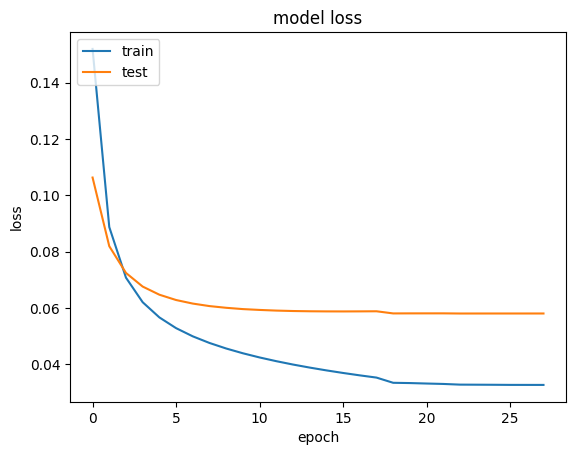

In [13]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [14]:
y_pred = model.predict(x_val)
print(y_pred)

5890/5890 [==============================] - 44s 7ms/step
[[0.99335265]
 [0.9494746 ]
 [0.8934235 ]
 ...
 [0.9787298 ]
 [0.87761104]
 [0.8034549 ]]


In [15]:
y_pred = y_pred.flatten()
y_pred

array([0.99335265, 0.9494746 , 0.8934235 , ..., 0.9787298 , 0.87761104,
       0.8034549 ], dtype=float32)

In [16]:
y_pred10 = y_pred * 5
y_pred10

array([4.9667635, 4.7473726, 4.4671173, ..., 4.893649 , 4.3880553,
       4.0172744], dtype=float32)

In [17]:
y_val10 = y_val * 5
y_val10 = y_val10.values
y_val10

array([5., 5., 5., ..., 5., 5., 4.], dtype=float32)

In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_val10, y_pred10))
print(rms)

for i in range(10):
    print("Predicted rating: {:.2f}".format(y_pred10[i]), "Actual rating: {:.2f}".format(y_val10[i]))

1.2041422519166713
Predicted rating: 4.97 Actual rating: 5.00
Predicted rating: 4.75 Actual rating: 5.00
Predicted rating: 4.47 Actual rating: 5.00
Predicted rating: 4.85 Actual rating: 5.00
Predicted rating: 4.62 Actual rating: 5.00
Predicted rating: 4.74 Actual rating: 5.00
Predicted rating: 4.97 Actual rating: 5.00
Predicted rating: 4.56 Actual rating: 5.00
Predicted rating: 4.98 Actual rating: 5.00
Predicted rating: 4.58 Actual rating: 5.00


In [19]:
model.save("recommendation")

INFO:tensorflow:Assets written to: recommendation/assets


INFO:tensorflow:Assets written to: recommendation/assets


In [17]:
!zip -r model.zip recommendation

  adding: recommendation/ (stored 0%)
  adding: recommendation/saved_model.pb (deflated 89%)
  adding: recommendation/variables/ (stored 0%)
  adding: recommendation/variables/variables.index (deflated 59%)
  adding: recommendation/variables/variables.data-00000-of-00001 (deflated 39%)
  adding: recommendation/keras_metadata.pb (deflated 81%)
  adding: recommendation/assets/ (stored 0%)
  adding: recommendation/fingerprint.pb (stored 0%)


In [20]:
user_embedding = model.user_embedding.get_weights()[0]
user_embedding.shape

(192751, 32)

In [21]:
recipe_embedding = model.recipe_embedding.get_weights()[0]
recipe_embedding.shape

(194084, 32)

In [22]:
# recommend recipes similar to given recipe
recipe_id = 192839
# get index of recipe
recipe_index = recipe2recipe_encoded[recipe_id]
recipe_index

6649

In [23]:
# get embedding of recipe
recipe_embedding[recipe_index]

array([ 7.1229962e-34,  4.1836342e-19, -6.8849292e-34,  1.0250752e-33,
       -4.7348619e-34, -1.3937587e-33, -9.9000046e-16, -6.0116083e-13,
        1.2550753e-34,  5.9715554e-34,  7.1801693e-34,  8.0145058e-34,
       -1.0491904e-33,  5.2060441e-34,  5.5882120e-34, -5.9250793e-34,
        3.6549058e-34,  1.3571788e-33, -4.4089854e-34,  8.4222995e-34,
       -4.1141324e-30, -3.7245832e-34, -1.3638805e-33, -3.3738987e-13,
       -9.2452631e-35,  1.5544443e-34,  3.8403400e-34, -9.4588210e-34,
        1.1456618e-33,  8.9734447e-34,  1.0000239e-33,  5.6089301e-34],
      dtype=float32)

In [24]:
# similar recipes using faiss
import faiss

index = faiss.IndexFlatIP(32)
index.add(recipe_embedding)

In [25]:
# get similar recipes
D, I = index.search(np.array([recipe_embedding[recipe_index]]), 11)

In [26]:
I

array([[ 39117,  27296,  42511,  42863,  45719,  13400,   6166, 124490,
        143564,  41902,  48891]])

In [27]:
# get recipe ids
recipe_ids = [recipe_encoded2recipe[x] for x in I[0]]
recipe_ids

[193609,
 15273,
 127930,
 109395,
 113552,
 152043,
 137954,
 145831,
 9518,
 17132,
 72037]

In [29]:
# get recipe ids from the df
df[df["recipe_id"].isin(recipe_ids)]

,user_id,recipe_id,date,rating,review,name,minutes,contributor_id,submitted,tags,...,protein,saturated_fat,carbohydrates,food_types,negative,neutral,positive,compound,user,recipe
384922,6538,137954,2009-01-22,5.0,so simple and delicious i cut the amounts in h...,kurdish baked fish,40,914002,2008-08-05,"60-minutes-or-less, time-to-make, course, main...",...,104.0,38.0,0.0,Veg,0.034,0.721,0.245,0.9308,595,6166
528559,4261,152043,2010-10-24,5.0,this delicious slaw was served alongside wiene...,healthier cole slaw,135,39835,2009-03-01,"time-to-make, course, main-ingredient, prepara...",...,2.0,2.0,5.0,Healthy,0.000,0.797,0.203,0.8807,488,13400
894528,20109,15273,2005-11-26,5.0,a fabulous low fat mushroom lovers recipe whic...,egg stuffed mushrooms,45,30534,2002-08-30,"60-minutes-or-less, time-to-make, course, main...",...,5.0,6.0,0.0,Healthy,0.010,0.732,0.258,0.9944,708,27296
639408,29804,193609,2016-07-15,5.0,made exactly as written for culinary quest 3 p...,mango float dessert,25,314579,2016-07-08,"30-minutes-or-less, time-to-make, course, main...",...,15.0,97.0,20.0,Non-veg,0.010,0.655,0.334,0.9887,166,39117
663561,15371,17132,2005-04-21,5.0,wow i made this about 2 months ago i cannot be...,awesome chicken cordon bleu,60,57408,2002-10-14,"60-minutes-or-less, time-to-make, course, main...",...,122.0,97.0,12.0,Non-veg,0.000,0.772,0.228,0.8055,20146,41902
110359,155182,127930,2015-09-07,2.0,how long does it need to be refrigerated for t...,the best blueberry cheesecake,75,407338,2008-03-14,"time-to-make, course, cuisine, preparation, oc...",...,19.0,126.0,16.0,Non-veg,0.000,0.909,0.091,0.3612,28217,42511
823871,23132,109395,2010-01-15,5.0,i could not find porcinis so i tried to find a...,zuppa di porcini porcini mushrooms soup,41,383346,2007-08-09,"60-minutes-or-less, time-to-make, course, main...",...,6.0,31.0,0.0,Healthy,0.037,0.634,0.329,0.9882,317,42863
360827,34260,113552,2007-09-30,4.0,yummy yummy yummy we polished these mashed pot...,chunky mashed potatoes,75,597959,2007-09-28,"time-to-make, course, main-ingredient, prepara...",...,21.0,81.0,28.0,Veg,0.000,0.573,0.427,0.9401,750,45719
663560,13982,17132,2005-02-27,5.0,thanks for sharing this recipe. it was great i...,awesome chicken cordon bleu,60,57408,2002-10-14,"60-minutes-or-less, time-to-make, course, main...",...,122.0,97.0,12.0,Non-veg,0.114,0.548,0.337,0.9601,16783,41902
860075,13184,72037,2012-04-17,5.0,tasty easy pork chop recipe i used bone in cho...,honey pork,45,130645,2006-03-12,"60-minutes-or-less, time-to-make, course, main...",...,48.0,7.0,4.0,Healthy,0.000,0.696,0.304,0.9446,21,48891


In [31]:
# recommend recipes for a user
user_id = 100
# get index of user
user_index = user2user_encoded[user_id]
user_index

12451

In [32]:
# get embedding of user
user_embedding[user_index]

array([ 1.34788060e-33,  1.01863492e-33,  5.48638478e-34, -9.96287298e-34,
       -8.79622423e-35,  5.51311259e-34,  7.96465014e-34,  7.61501404e-34,
        9.85555035e-34,  1.44162627e-33, -6.06080479e-34,  1.14573965e-33,
        1.02745553e-33,  1.27395229e-33,  1.76747331e-34,  1.66926075e-34,
        1.41425782e-33, -2.59552091e-34, -3.41760289e-35,  2.21286812e-35,
        1.03254248e-33, -4.14039967e-34, -1.30334552e-33, -1.04768579e-33,
       -2.66941037e-13, -2.11308334e-34,  6.03262231e-34, -1.12993807e-33,
        1.21415783e-33, -2.37568878e-34,  3.99337471e-34, -1.41367155e-33],
      dtype=float32)

In [33]:
# save recipe2recipe_encoded to json
import json

with open('recipe2recipe_encoded.json', 'w') as fp:
    json.dump(recipe2recipe_encoded, fp)

In [34]:
with open('user2user_encoded.json', 'w') as fp:
    json.dump(user2user_encoded, fp)